1. Design a process that stays in the interval $[a,b]$ and mean-reverts around $\frac{b-a}{с}$, $c \sim \mathcal{U}(a,b)$.

Generate a path and plot it in graph and add the mean line.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [154]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state=None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state

        # Default Wiener Process
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1

    def sampler_init_state(self):
        return np.zeros(self.Nx)

    def EulerSolution(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.sampler_init_state()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            dwt = np.random.normal(0, 1, size=self.Nx) * np.sqrt(dt)
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt
        return t_data, x_data

class MeanRevertingProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [a, b, k, sigma]
        self.a = self.params[0]  # Нижняя граница
        self.b = self.params[1]  # Верхняя граница
        self.k = self.params[2]  # Скорость возврата к среднему
        self.sigma = self.params[3]  # Волатильность
        self.c = np.random.uniform(self.a, self.b)  # Случайный параметр c из равномерного распределения

        # Средний уровень возврата
        self.mean_level = (self.b - self.a) / self.c

    def sampler_init_state(self):
        # Инициализируем значение как случайное в пределах [a, b]
        return np.random.uniform(self.a, self.b, self.Nx)

    def EulerSolution(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        # Инициализация первого шага
        x_data[0] = self.sampler_init_state()

        for i in range(1, self.Nt + 1):
            dwt = np.random.normal(0, 1, size=self.Nx) * np.sqrt(dt)
            # Модель обратного к среднему с учетом случайного параметра c
            dx = self.k * (self.mean_level - x_data[i - 1]) * dt + self.sigma * dwt
            x_data[i] = x_data[i - 1] + dx

            # Применяем ограничения на границы
            x_data[i] = np.clip(x_data[i], self.a, self.b)

        return t_data, x_data

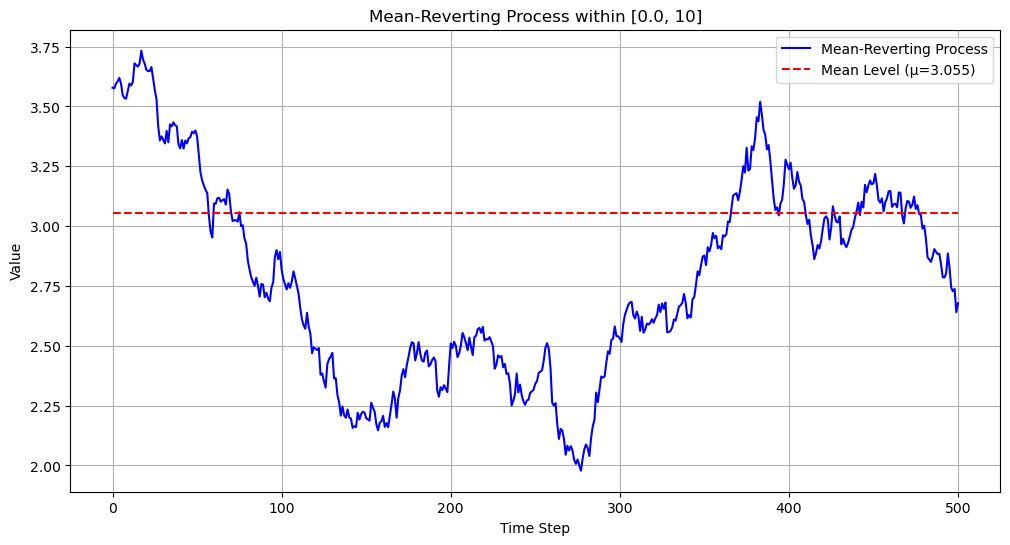

In [173]:
params = [0.0, 10, 0.2, 0.3]  # [a, b, k, sigma]
T = 10
Nx = 1   
Nt = 500

# Создаем объект класса
mean_reverting = MeanRevertingProcess(params, T, Nx, Nt)

# Генерация процесса
time, path = mean_reverting.EulerSolution()

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(path, label='Mean-Reverting Process', color='blue')
plt.hlines(mean_reverting.mean_level, xmin=0, xmax=Nt, colors='red', linestyles='dashed', label=f'Mean Level (μ={mean_reverting.mean_level:.3f})')
plt.title(f'Mean-Reverting Process within [{mean_reverting.a}, {mean_reverting.b}]')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

2. Simulate a Cox-Ingersoll-Ross (CIR) process
$$
dX_t = (6 - 2X_t)dt + θ\sqrt{X_t}dW_t, X(0)=1,
$$
where $θ = θ_1 = 1$ for $t < τ_0 = 0.6$ and $θ = θ_2$ for $t ≥ τ_0$, $t \in (0, 1)$.

Plot the simulated path, plot the shape of statistic $|\hat{D}_k|$ and
identify the change-point $k_0$ on a time-serie and compare result with $\tau_0$.

**Hint (Iacus, 2008, p. 212).** Consider the $\sigma(x)$ is constant and $b(x)$ can be estimated
$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)},
$$
then use residuals
$$
Z_i = \frac{(X_{i+1} - X_i) - \hat{b}(X_i)\Delta_n}{\sqrt{\Delta_n}},
$$
and compute the statistic
$$
\hat{V}_k = \left(\frac{k(n-k)}{n^2}\right)^{1/2} \left(\frac{\hat{S}_{n-k}}{n-k}
- \frac{\hat{S}_k}{k}\right)
 = \frac{\hat{S}_n \hat{D}_k}{\sqrt{n-k}},
$$
where
$\hat{S}_k = \sum_{i=1}^k \hat{Z}_i^2$,
$\hat{S}_{n-k} = \sum_{i=k+1}^n \hat{Z}_i^2$, and $\hat{D}_k = \frac kn - \frac{\hat{S}_k}{\hat{S}_n}.$

Finally the change-point is identifed as the solution to
$$
\hat{k}_0 = \arg \min_k |\hat{D}_k|.
$$

Expected result is:

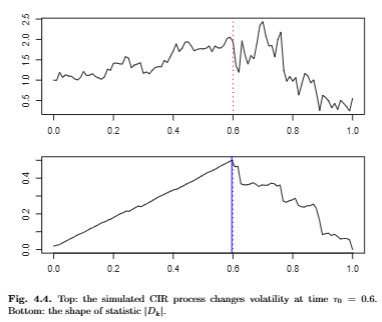

https://forecastegy.com/posts/change-point-detection-time-series-python/

https://github.com/amanahuja/change-detection-tutorial

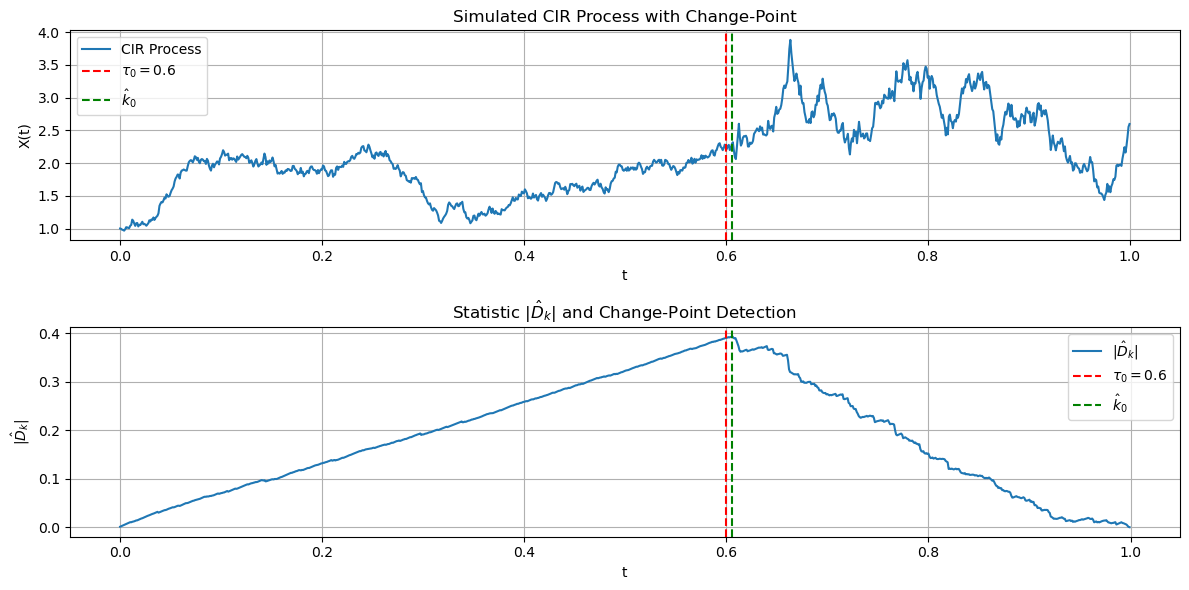

In [183]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Симуляция процесса CIR
def simulate_CIR(T, Nt, X0, theta1, theta2, tau0):
    dt = T / Nt
    t_data = np.linspace(0, T, Nt + 1)
    X_data = np.zeros(Nt + 1)
    X_data[0] = X0

    for i in range(1, Nt + 1):
        theta = theta1 if t_data[i - 1] < tau0 else theta2
        dW = np.random.normal(0, np.sqrt(dt))
        drift = (6 - 2 * X_data[i - 1]) * dt
        diffusion = theta * np.sqrt(max(X_data[i - 1], 0)) * dW
        X_data[i] = max(X_data[i - 1] + drift + diffusion, 0)
    return t_data, X_data

# 2. Оценка b(x) с использованием ядровой оценки
def kernel_density_estimate(x, X, h):
    K = lambda u: np.exp(-u**2 / 2) / np.sqrt(2 * np.pi)
    weights = K((x - X) / h)
    return weights / np.sum(weights)

def estimate_b(X, dt, h):
    n = len(X) - 1
    b_hat = np.zeros(n)
    for i in range(n):
        x = X[i]
        weights = kernel_density_estimate(x, X[:-1], h)
        b_hat[i] = np.sum(weights * (X[1:] - X[:-1])) / (dt * np.sum(weights))
    return b_hat

# 3. Вычисление статистики \hat{D}_k
def compute_statistics(X, b_hat, dt):
    n = len(X) - 1
    residuals = (X[1:] - X[:-1] - b_hat * dt) / np.sqrt(dt)
    S_k = np.cumsum(residuals**2)
    S_n = S_k[-1]
    D_k = np.arange(1, n + 1) / n - S_k / S_n
    return np.abs(D_k), S_k

# Симуляция данных
T = 1
Nt = 1000
X0 = 1
theta1 = 1.0
theta2 = 2.0
tau0 = 0.6

t_data, X_data = simulate_CIR(T, Nt, X0, theta1, theta2, tau0)

# Оценка b(x) с ядровой оценкой
h = 0.1
b_hat = estimate_b(X_data, T / Nt, h)

# Вычисление статистики \hat{D}_k
D_k, S_k = compute_statistics(X_data, b_hat, T / Nt)

# Находим k_0 как индекс минимального значения D_k
k_0 = np.argmax(D_k)

# Вычисляем время изменения на основе t_data, соответствующее индексу k_0
t_change = t_data[k_0]

# Построение графиков
plt.figure(figsize=(12, 6))

# График процесса CIR
plt.subplot(2, 1, 1)
plt.plot(t_data, X_data, label='CIR Process')
plt.axvline(x=tau0, color='red', linestyle='--', label=r'$\tau_0 = 0.6$')
plt.axvline(x=t_change, color='green', linestyle='--', label=r'$\hat{k}_0$')
plt.title('Simulated CIR Process with Change-Point')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.legend()
plt.grid()

# График статистики |\hat{D}_k|
plt.subplot(2, 1, 2)
plt.plot(t_data[:-1], D_k, label=r'$|\hat{D}_k|$')
plt.axvline(x=tau0, color='red', linestyle='--', label=r'$\tau_0 = 0.6$')
plt.axvline(x=t_change, color='green', linestyle='--', label=r'$\hat{k}_0$')
plt.title(r'Statistic $|\hat{D}_k|$ and Change-Point Detection')
plt.xlabel('t')
plt.ylabel(r'$|\hat{D}_k|$')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


3. Simulate and plot 100 trajectories of the process
$$
dX_t = (0.03tX_t – X^3_t)dt + 0.1dW_t
$$
with the 1st Milstein scheme, $x_0=0$, $t_0=0$, $T=100$, and $\Delta t=0.01$.

Add an average trajectory and confidence interval on the graph.

In [46]:

T = 100 # Total time
dt = 0.01 # Time step
N = int(T / dt) # Number of time steps
x0 = 0 # Initial value
num_trajectories = 100 # Number of trajectories
t_values = np.linspace(0, T, N+1)

# Function to simulate the process with the 1st order Milstein scheme
def simulate_milstein(dt, N, x0, num_trajectories):
    trajectories = np.zeros((num_trajectories, N+1))
    trajectories[:, 0] = x0

    for i in range(1, N+1):
        t = (i - 1) * dt
        dW = np.random.normal(0, np.sqrt(dt), size=num_trajectories)
        x_prev = trajectories[:, i-1]
        drift = (0.03 * t * x_prev - x_prev**3) * dt
        diffusion = 0.1 * dW
        correction = 0.1 * 0.1 * 0.5 * dW**2
        trajectories[:, i] = x_prev + drift + diffusion + correction

    return trajectories

trajectories = simulate_milstein(dt, N, x0, num_trajectories)


mean_trajectory = np.mean(trajectories, axis=0)
std_trajectory = np.std(trajectories, axis=0)
lower_bound = mean_trajectory - 1.96 * std_trajectory
upper_bound = mean_trajectory + 1.96 * std_trajectory

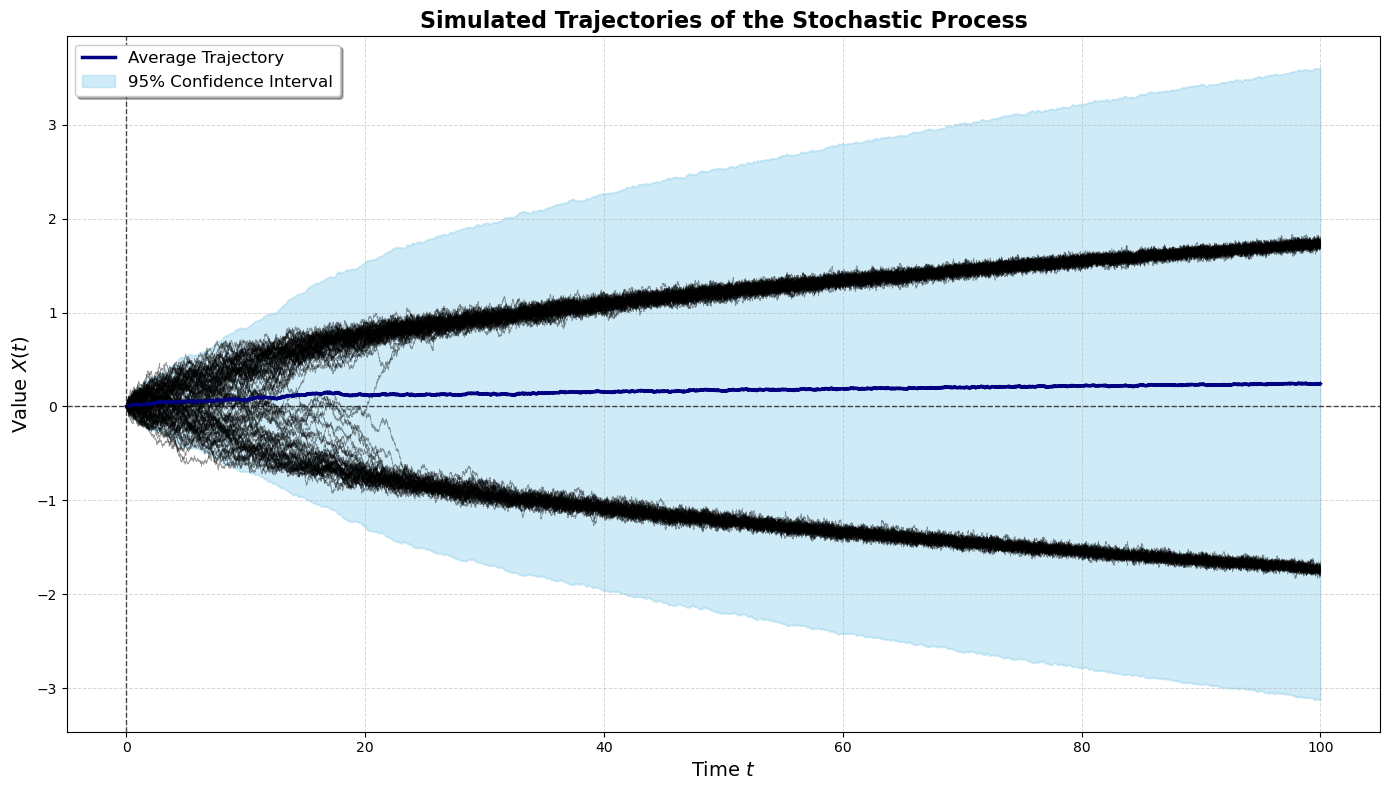

In [49]:
plt.figure(figsize=(14, 8))

for i in range(num_trajectories):
    plt.plot(t_values, trajectories[i, :], color="black", alpha=0.4, linewidth=0.5, label="_nolegend_")


plt.plot(t_values, mean_trajectory, color="navy", label="Average Trajectory", linewidth=2.5)

plt.fill_between(t_values, lower_bound, upper_bound, color="skyblue", alpha=0.4, label="95% Confidence Interval")

plt.title("Simulated Trajectories of the Stochastic Process", fontsize=16, fontweight="bold")
plt.xlabel("Time $t$", fontsize=14)
plt.ylabel("Value $X(t)$", fontsize=14)
plt.legend(loc="upper left", fontsize=12, frameon=True, shadow=True)
plt.grid(alpha=0.5, linestyle="--", linewidth=0.7)
plt.tight_layout()

plt.axhline(0, color="black", linewidth=1, linestyle="--", alpha=0.7)
plt.axvline(0, color="black", linewidth=1, linestyle="--", alpha=0.7)

plt.show()


4. Implement a non-parametric drift and diffusion estimators for the Ornstein-Uhlenbeck model
$$
dX_t = (θ_1 - θ_2X_t)dt + θ_3 dW_t,
X(0) = 10,  θ = (0, 3, 2).
$$

Use
*   uniform kernel $K(u) = 1/2$,
*   Epanechnikov (parabolic) kernel $K(u) = \frac{3}{4}(1 - u^2)$,
*   Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$,

and plot the estimations on the graph.


In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for Ornstein-Uhlenbeck model
theta = (0, 3, 2)  # θ1 = 0, θ2 = 3, θ3 = 2
X0 = 10
T = 10
dt = 0.01
N = int(T / dt) + 1

np.random.seed(42)
t_values = np.linspace(0, T, N)
dW = np.random.normal(0, np.sqrt(dt), N)
X = np.zeros(N)
X[0] = X0
for i in range(1, N):
    drift = (theta[0] - theta[1] * X[i-1]) * dt
    diffusion = theta[2] * dW[i-1]
    X[i] = X[i-1] + drift + diffusion

# Kernel functions
def uniform_kernel(u):
    return 0.5 * (np.abs(u) <= 1)

def epanechnikov_kernel(u):
    return 0.75 * (1 - u**2) * (np.abs(u) <= 1)

def gaussian_kernel(u):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u**2)


def drift_estimator(X, kernel, h):
    drift = np.zeros(len(X) - 1)  
    for i, x in enumerate(X[:-1]):
        weights = kernel((x - X[:-1]) / h)  
        drift[i] = np.sum(weights * (X[1:] - X[:-1])) / (np.sum(weights) * dt)
    return drift

def diffusion_estimator(X, kernel, h):
    diffusion = np.zeros(len(X) - 1)  
    for i, x in enumerate(X[:-1]):
        weights = kernel((x - X[:-1]) / h) 
        diffusion[i] = np.sqrt(np.sum(weights * (X[1:] - X[:-1])**2) / (np.sum(weights) * dt))
    return diffusion

# Bandwidth
h = 0.5

drift_uniform = drift_estimator(X, uniform_kernel, h)
diffusion_uniform = diffusion_estimator(X, uniform_kernel, h)

drift_epanechnikov = drift_estimator(X, epanechnikov_kernel, h)
diffusion_epanechnikov = diffusion_estimator(X, epanechnikov_kernel, h)

drift_gaussian = drift_estimator(X, gaussian_kernel, h)
diffusion_gaussian = diffusion_estimator(X, gaussian_kernel, h)


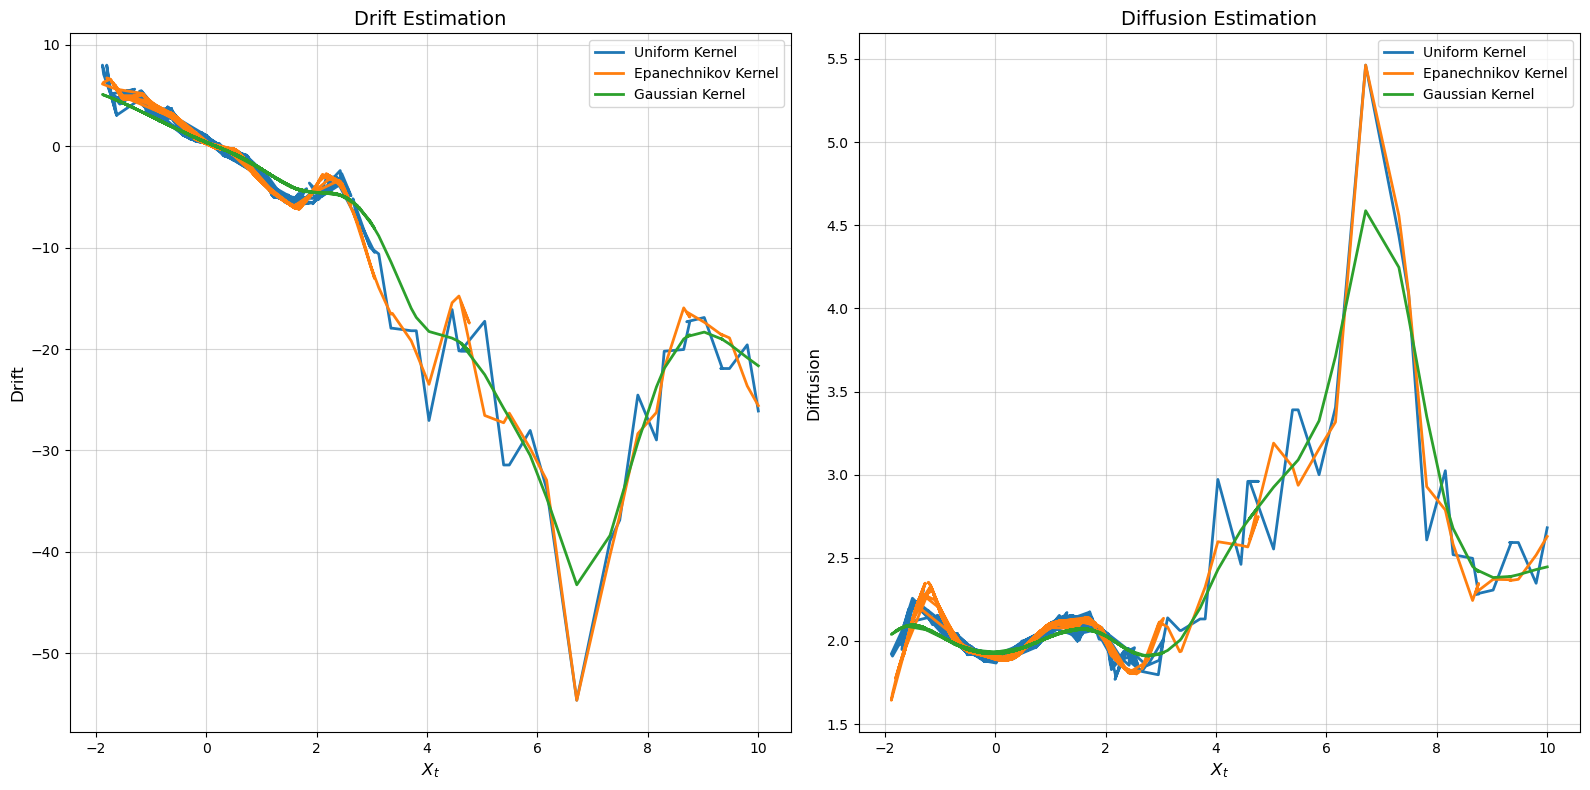

In [57]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(X[:-1], drift_uniform, label="Uniform Kernel", linewidth=2)
plt.plot(X[:-1], drift_epanechnikov, label="Epanechnikov Kernel", linewidth=2)
plt.plot(X[:-1], drift_gaussian, label="Gaussian Kernel", linewidth=2)
plt.title("Drift Estimation", fontsize=14)
plt.xlabel("$X_t$", fontsize=12)
plt.ylabel("Drift", fontsize=12)
plt.legend()
plt.grid(alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot(X[:-1], diffusion_uniform, label="Uniform Kernel", linewidth=2)
plt.plot(X[:-1], diffusion_epanechnikov, label="Epanechnikov Kernel", linewidth=2)
plt.plot(X[:-1], diffusion_gaussian, label="Gaussian Kernel", linewidth=2)
plt.title("Diffusion Estimation", fontsize=14)
plt.xlabel("$X_t$", fontsize=12)
plt.ylabel("Diffusion", fontsize=12)
plt.legend()
plt.grid(alpha=0.5)

plt.tight_layout()
plt.show()

5. Estimate the parameters of a random process. As candidates use
*   Ornstein-Uhlenbeck process,
*   Geometric Brownian motion process,
*   Cox-Ingersoll-Ross process.

Plot three models in a graph and choose the best one. Provide the proof of your solution.

Time-series (*. csv) in the [folder](https://drive.google.com/drive/folders/1tzHl3-7jMtRiGgFe5suqT2CzftZ0o9cB?usp=sharing).

In [124]:
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from scipy.stats import ks_2samp

<Axes: >

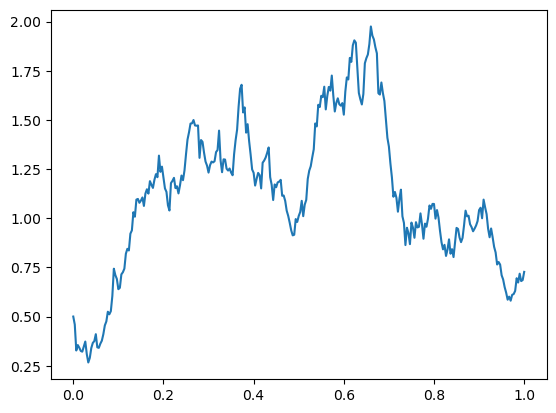

In [125]:
time_series = pd.read_csv('8.csv', index_col=0)['0']
time_series.plot()

In [126]:
def ou_process(params, t, x0):
    mu, theta, sigma = params
    dt = t[1] - t[0]
    x = np.zeros(len(t))
    x[0] = x0 
    for i in range(1, len(t)):
        dx = -theta * (x[i-1] - mu) * dt + sigma * np.sqrt(dt) * np.random.normal()
        x[i] = x[i-1] + dx
    return x


def gbm_process(params, t, x0):
    mu, sigma = params
    dt = t[1] - t[0]
    x = np.zeros(len(t))
    x[0] = x0 
    for i in range(1, len(t)):
        dx = mu * x[i-1] * dt + sigma * x[i-1] * np.sqrt(dt) * np.random.normal()
        x[i] = x[i-1] + dx
    return x


def cir_process(params, t, x0, epsilon=1e-6):
    theta, kappa, sigma = params
    dt = t[1] - t[0]
    x = np.zeros(len(t))
    x[0] = x0 
    for i in range(1, len(t)):
        dx = kappa * (theta - x[i-1]) * dt + sigma * np.sqrt(np.maximum(x[i-1], epsilon) * dt) * np.random.normal()
        x[i] = x[i-1] + dx
        x[i] = np.maximum(x[i], epsilon)
    return x


def fit_process_with_ks(model, initial_params, t, x0, time_series):
    def objective(params):
        simulated_data = model(params, t, x0)
        # Применение критерия Колмогорова-Смирнова для сравнения распределений
        ks_stat, _ = ks_2samp(time_series, simulated_data)
        return ks_stat  # Минимизируем значение KS-статистики
    
    result = minimize(objective, initial_params, bounds=[(None, None)] * len(initial_params))
    return result.x

t = np.linspace(0, 1, len(time_series))

# Инициализация параметров для поиска
initial_params_ou = [0.5, 1.0, 0.8]  
initial_params_gbm = [0.05, 0.8]  
initial_params_cir = [0.5, 0.5, 0.8]  


x0_ou = time_series.iloc[0]  
x0_gbm = time_series.iloc[0]  
x0_cir = time_series.iloc[0] 


params_ou = fit_process_with_ks(ou_process, initial_params_ou, t, x0_ou, time_series)
params_gbm = fit_process_with_ks(gbm_process, initial_params_gbm, t, x0_gbm, time_series)
params_cir = fit_process_with_ks(cir_process, initial_params_cir, t, x0_cir, time_series)


ou_simulated = ou_process(params_ou, t, x0_ou)
gbm_simulated = gbm_process(params_gbm, t, x0_gbm)
cir_simulated = cir_process(params_cir, t, x0_cir)


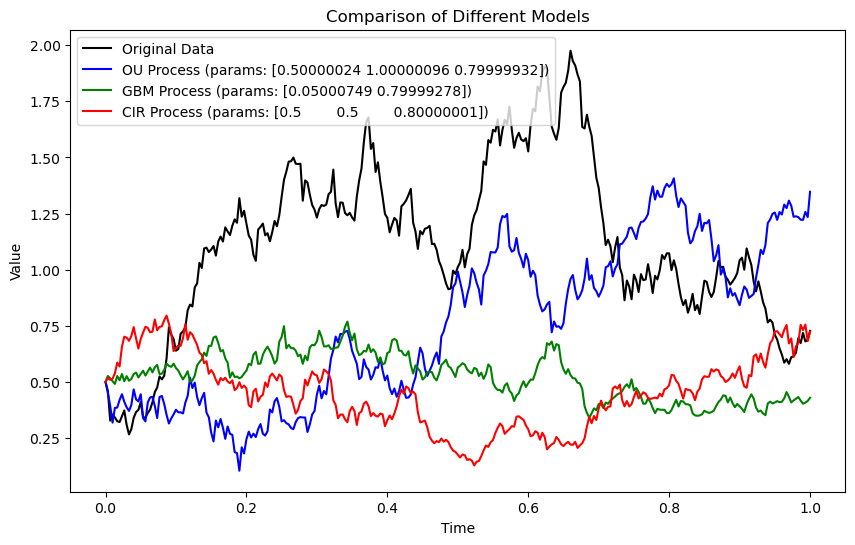

KS statistic for OU Process: 0.3588039867109635
KS statistic for GBM Process: 0.8372093023255814
KS statistic for CIR Process: 0.8205980066445183
Best model: OU with KS-statistic: 0.3588039867109635


In [127]:
plt.figure(figsize=(10, 6))
plt.plot(t, time_series, label='Original Data', color='black')
plt.plot(t, ou_simulated, label=f'OU Process (params: {params_ou})', color='blue')
plt.plot(t, gbm_simulated, label=f'GBM Process (params: {params_gbm})', color='green')
plt.plot(t, cir_simulated, label=f'CIR Process (params: {params_cir})', color='red')
plt.legend()
plt.title('Comparison of Different Models')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

ks_ou = ks_2samp(time_series, ou_simulated)[0]
ks_gbm = ks_2samp(time_series, gbm_simulated)[0]
ks_cir = ks_2samp(time_series, cir_simulated)[0]

print(f'KS statistic for OU Process: {ks_ou}')
print(f'KS statistic for GBM Process: {ks_gbm}')
print(f'KS statistic for CIR Process: {ks_cir}')

# Выводим наилучшую модель на основе KS-метрики
best_model = min([(ks_ou, 'OU'), (ks_gbm, 'GBM'), (ks_cir, 'CIR')], key=lambda x: x[0])
print(f'Best model: {best_model[1]} with KS-statistic: {best_model[0]}')